In [1]:
import pandas as pd
import pyreadr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)  # For reproducible results

In [2]:
# Define the variables for our mental health analysis
# These represent various social, demographic, and behavioral factors
analysis_variables = [
    "SC_AGE_YEARS",    # Child's age in years
    #"HHCOUNT",         # Household count
    #"BORNUSA",         # Born in USA indicator
    "K8Q35",           # School engagement measure
    #"ACE12",           # Adverse childhood experience - discrimination
    "PHYSACTIV",       # Physical activity level
    "age3_22",         # Age group categories
    "sex_22",          # Child's sex
    #"MotherMH_22",     # Mother's mental health status
    #"FatherMH_22",     # Father's mental health status
    "ScreenTime_22",   # Screen time categories
    "ACEct11_22",      # ACE count measure
    "ACE4ctCom_22",    # Community ACE measure
    "SC_RACE_R",       # Child's race/ethnicity
    "bully_22",        # Bullying others indicator
    "bullied_22",      # Being bullied indicator
    "AftSchAct_22",    # After-school activities participation
    "EventPart_22",    # Event participation
    "mentor_22",       # Mentorship availability
    "ShareIdeas_22",   # Sharing ideas with family
    #"ACE6ctHH_22",     # Household ACE count
    #"NbhdSupp_22",     # Neighborhood support
    #"NbhdSafe_22",     # Neighborhood safety
    "FAMILY_R",        # Family structure
    "MHealthConcern"   # Our target variable (mental health concerns)
]

print(f"📋 Analysis will include {len(analysis_variables)-1} predictor variables")
print(f"🎯 Target variable: MHealthConcern")
print("\nVariables selected for analysis:")
for i, var in enumerate(analysis_variables[:-1], 1):
    print(f"{i:2d}. {var}")

📋 Analysis will include 16 predictor variables
🎯 Target variable: MHealthConcern

Variables selected for analysis:
 1. SC_AGE_YEARS
 2. K8Q35
 3. PHYSACTIV
 4. age3_22
 5. sex_22
 6. ScreenTime_22
 7. ACEct11_22
 8. ACE4ctCom_22
 9. SC_RACE_R
10. bully_22
11. bullied_22
12. AftSchAct_22
13. EventPart_22
14. mentor_22
15. ShareIdeas_22
16. FAMILY_R


In [3]:
def load_data():

    result = pyreadr.read_r('/home/msmitty/Documents/BINF620/BINF620-R Projects/Final Project/binf620_FinalProject - Delivered/currData_NSCH.RData')
    # Let's explore what we got
    print("Objects in the .rdata file:")
    for key in result.keys():
        print(f"- {key}: {type(result[key])}")

    # If you know there's a specific data frame you want, access it directly
    # Replace 'df_name' with the actual name of your data frame
    if 'df_name' in result:
        df = result['df_name']
        print(df.head())
    else:
        # If you're not sure of the name, grab the first object
        first_key = list(result.keys())[0]
        df = result[first_key]
        print(f"Using object '{first_key}':")
        print(df.head())
    
    return df

In [5]:
def preprocess_for_pca(df):
    """
    Comprehensive preprocessing specifically designed for PCA analysis.
    PCA requires complete numerical data, so we handle missing values and encoding carefully.
    """
    print("🔄 Starting comprehensive data preprocessing...")
    
    # Separate features and target
    X = df.drop('MHealthConcern', axis=1).copy()
    y = df['MHealthConcern'].copy()
    
    print(f"📊 Original feature matrix shape: {X.shape}")
    print(f"🎯 Target variable distribution:")
    print(f"   No mental health concerns: {(y==0).sum()} ({(y==0).mean():.3f})")
    print(f"   Mental health concerns: {(y==1).sum()} ({(y==1).mean():.3f})")
    
    # Check for missing values
    missing_counts = X.isnull().sum()
    if missing_counts.sum() > 0:
        print(f"\n⚠️  Found missing values in {(missing_counts > 0).sum()} variables:")
        for var, count in missing_counts[missing_counts > 0].items():
            print(f"   {var}: {count} missing ({count/len(X):.3f})")
    else:
        print("\n✅ No missing values detected")
    
    # Handle missing values using appropriate strategies
    # For numerical variables: use median imputation
    numerical_cols = X.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0 and X[numerical_cols].isnull().sum().sum() > 0:
        print(f"🔧 Imputing {len(numerical_cols)} numerical variables with median...")
        num_imputer = SimpleImputer(strategy='median')
        X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])
    
    # For categorical variables: use most frequent value
    categorical_cols = X.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"🔧 Imputing {len(categorical_cols)} categorical variables with mode...")
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])
    
    # Ensure all variables are numerical for PCA
    # Convert any remaining categorical variables to numerical
    label_encoders = {}
    for column in X.columns:
        if X[column].dtype == 'object' or len(X[column].unique()) < 10:
            print(f"🔢 Encoding categorical variable: {column}")
            le = LabelEncoder()
            X[column] = le.fit_transform(X[column].astype(str))
            label_encoders[column] = le
    
    # Convert everything to float for PCA
    X = X.astype(float)
    
    print(f"\n✅ Preprocessing complete!")
    print(f"📊 Final feature matrix shape: {X.shape}")
    print(f"🔢 All variables are now numerical and ready for PCA")
    
    return X, y, label_encoders

# Preprocess the data
df = load_data()
df = df[analysis_variables]
X, y, encoders = preprocess_for_pca(df)

Objects in the .rdata file:
- currData: <class 'pandas.core.frame.DataFrame'>
Using object 'currData':
   SC_AGE_YEARS  PLACESLIVED  HHCOUNT  FAMCOUNT  K2Q33A  K2Q33B  K2Q32A  \
0             5            1        4         4       2      95       2   
1             8            1        3         3       1       2       2   
2             5            1        5         5       2      95       2   
3             6            1        4         4       2      95       2   
4            17            1        3         3       2      95       2   

   K2Q32B  FASD  K2Q37A  ...  RecCentr_22  library_22  NbhdAmenities_22  \
0      95     2       2  ...            1           1                 4   
1      95     2       2  ...            2           2                 2   
2      95     2       2  ...            2           2                 2   
3      95     2       2  ...            1           1                 4   
4      95     2       2  ...            2           2                 1

🔍 EXPLORATORY DATA ANALYSIS

🎯 Top 10 variables correlated with mental health concerns:
 1. SC_AGE_YEARS   :  0.303 (📈 Higher values → more MH concerns)
 2. age3_22        :  0.291 (📈 Higher values → more MH concerns)
 3. PHYSACTIV      : -0.284 (📉 Lower values → more MH concerns)
 4. mentor_22      : -0.227 (📉 Lower values → more MH concerns)
 5. bully_22       : -0.215 (📉 Lower values → more MH concerns)
 6. AftSchAct_22   : -0.207 (📉 Lower values → more MH concerns)
 7. ScreenTime_22  :  0.207 (📈 Higher values → more MH concerns)
 8. EventPart_22   : -0.191 (📉 Lower values → more MH concerns)
 9. ShareIdeas_22  : -0.176 (📉 Lower values → more MH concerns)
10. bullied_22     : -0.147 (📉 Lower values → more MH concerns)


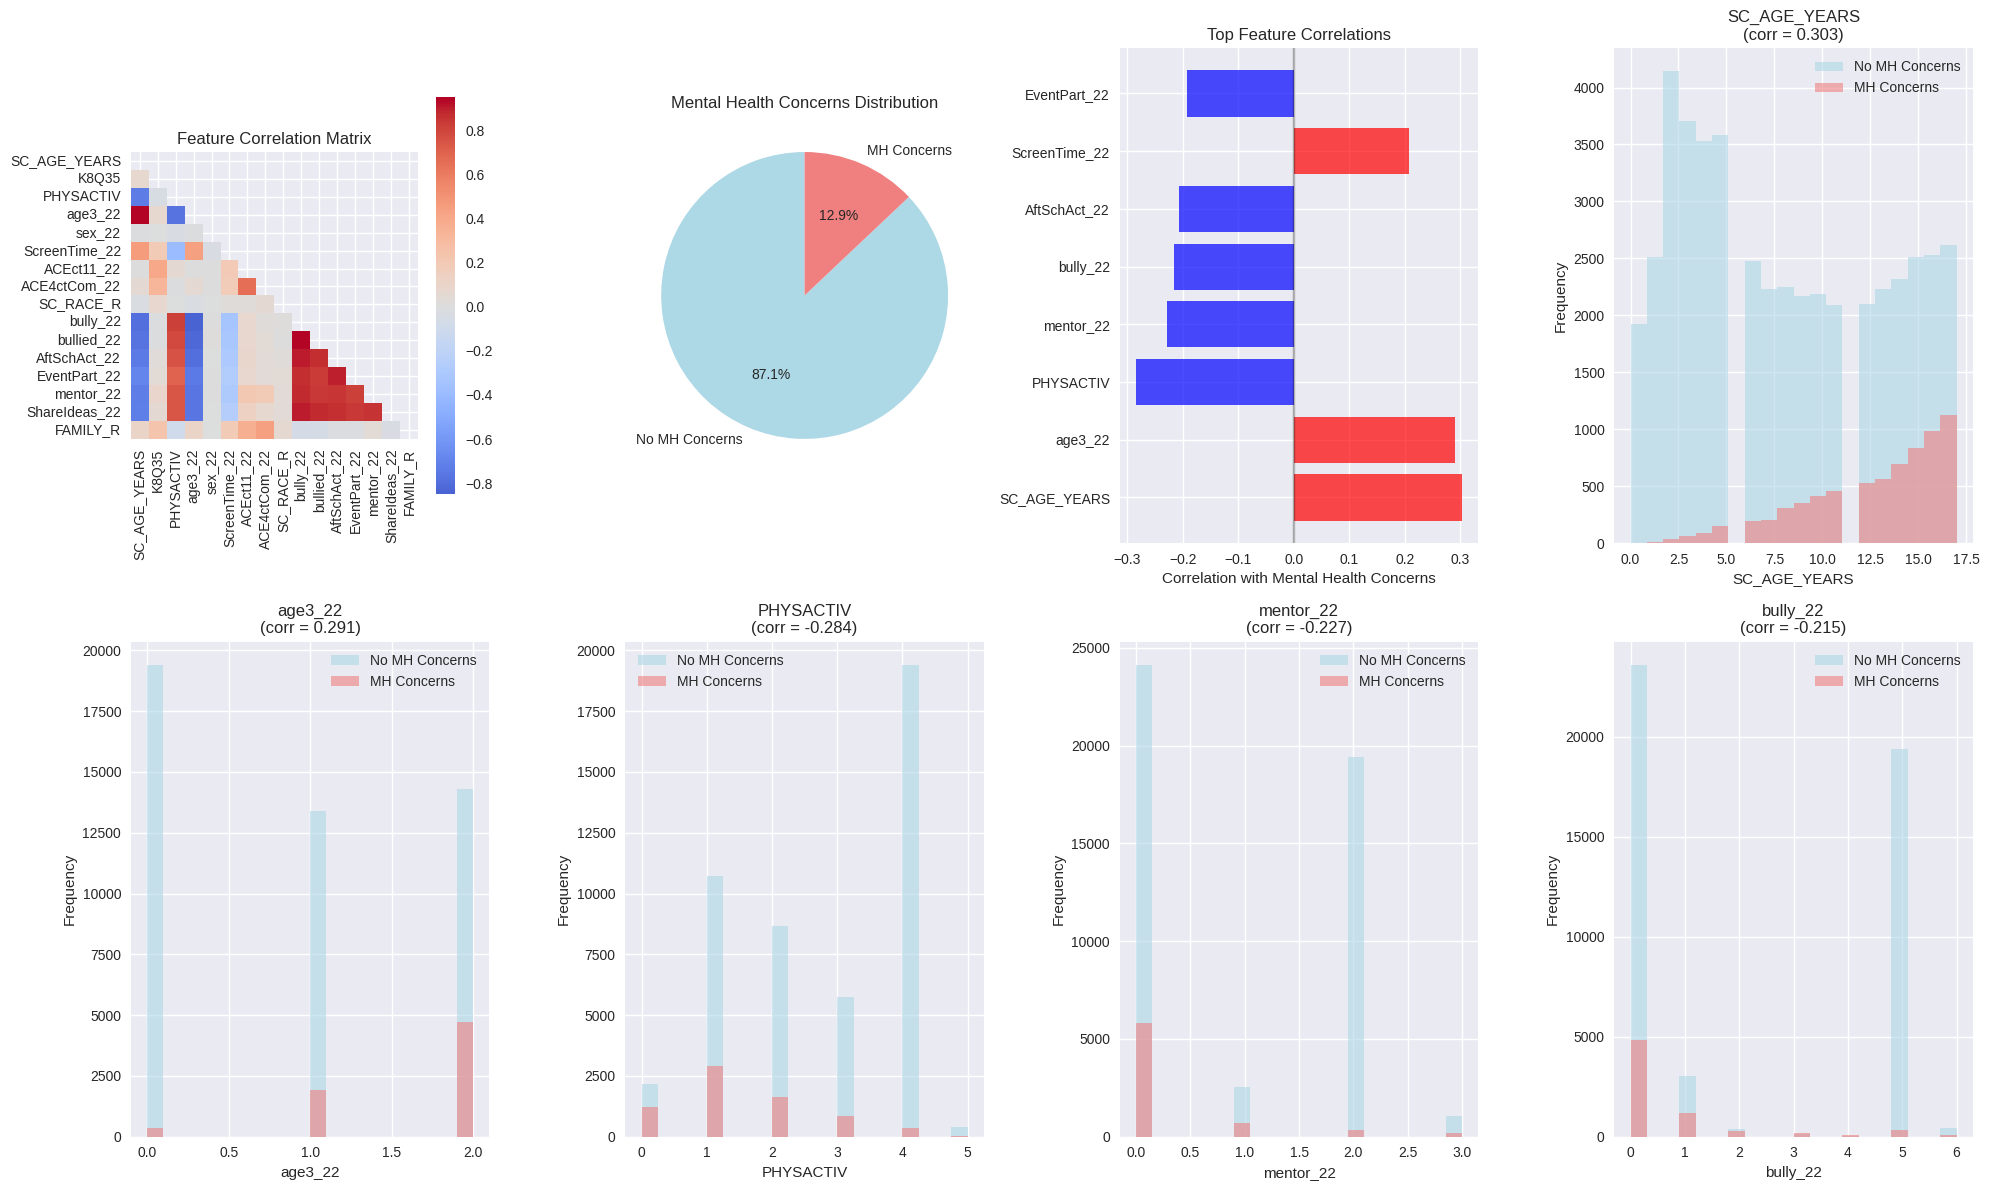

In [6]:
def explore_mental_health_data(X, y):
    """
    Conduct exploratory analysis to understand relationships in the data.
    This helps us interpret PCA results more meaningfully.
    """
    print("🔍 EXPLORATORY DATA ANALYSIS")
    print("="*50)
    
    # Calculate correlations between features and target
    feature_target_corrs = []
    for col in X.columns:
        corr = np.corrcoef(X[col], y)[0,1]
        if not np.isnan(corr):  # Handle any potential NaN correlations
            feature_target_corrs.append((col, corr))
    
    # Sort by absolute correlation strength
    feature_target_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\n🎯 Top 10 variables correlated with mental health concerns:")
    for i, (feature, corr) in enumerate(feature_target_corrs[:10], 1):
        direction = "📈 Higher" if corr > 0 else "📉 Lower"
        print(f"{i:2d}. {feature:15s}: {corr:6.3f} ({direction} values → more MH concerns)")
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Correlation heatmap of all features
    plt.subplot(2, 4, 1)
    corr_matrix = X.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show only lower triangle
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix')
    
    # 2. Distribution of target variable
    plt.subplot(2, 4, 2)
    target_counts = y.value_counts()
    colors = ['lightblue', 'lightcoral']
    plt.pie(target_counts.values, labels=['No MH Concerns', 'MH Concerns'], 
            autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Mental Health Concerns Distribution')
    
    # 3. Top correlations bar plot
    plt.subplot(2, 4, 3)
    top_features = [item[0] for item in feature_target_corrs[:8]]
    top_corrs = [item[1] for item in feature_target_corrs[:8]]
    colors = ['red' if corr > 0 else 'blue' for corr in top_corrs]
    bars = plt.barh(range(len(top_features)), top_corrs, color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Correlation with Mental Health Concerns')
    plt.title('Top Feature Correlations')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # 4-8. Distribution plots for top 5 correlated features
    for i, (feature, corr) in enumerate(feature_target_corrs[:5], 4):
        plt.subplot(2, 4, i)
        
        # Create separate distributions for each mental health group
        no_concern = X.loc[y == 0, feature]
        concern = X.loc[y == 1, feature]
        
        plt.hist(no_concern, alpha=0.6, label='No MH Concerns', bins=20, color='lightblue')
        plt.hist(concern, alpha=0.6, label='MH Concerns', bins=20, color='lightcoral')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'{feature}\n(corr = {corr:.3f})')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return feature_target_corrs

# Perform exploratory analysis
correlations = explore_mental_health_data(X, y)

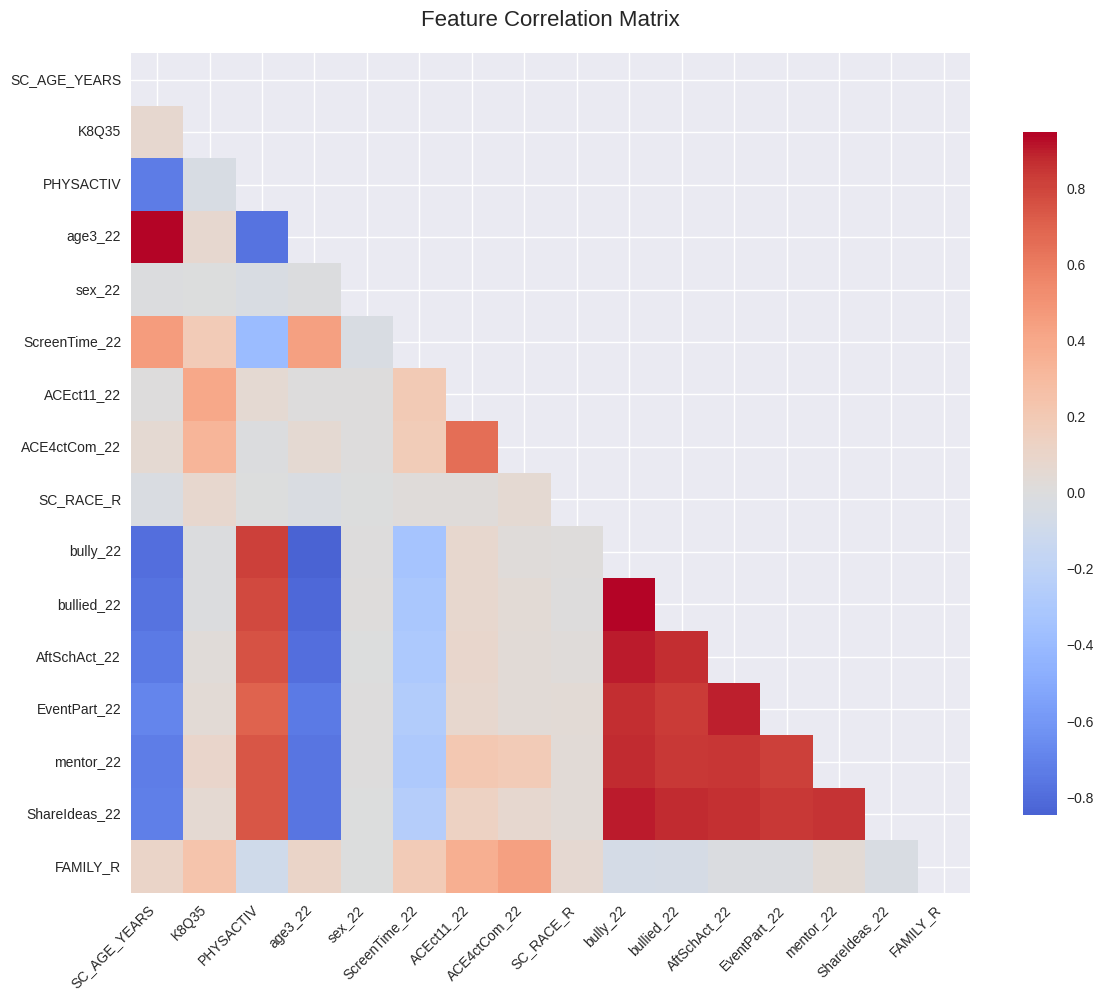

In [7]:
# 1. Correlation heatmap of all features
# Create a larger figure with better proportions
plt.figure(figsize=(12, 10))  # Significantly larger than default

corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create the heatmap with improved spacing
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})

plt.title('Feature Correlation Matrix', fontsize=16, pad=20)  # Larger title with padding
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-labels at 45 degrees
plt.yticks(rotation=0, fontsize=10)  # Keep y-labels horizontal
plt.tight_layout()  # Automatically adjust spacing
plt.show()

🔍 DETERMINING OPTIMAL NUMBER OF COMPONENTS
📏 Standardizing features for PCA...
✅ Features standardized (mean=0, std=1)

📊 Component Selection Criteria:
   Kaiser criterion (eigenvalues > 1): 4 components
   80% variance explained: 5 components
   90% variance explained: 8 components
   Elbow method suggestion: 4 components

🎯 Selected optimal components: 4
   This captures 0.756 of total variance


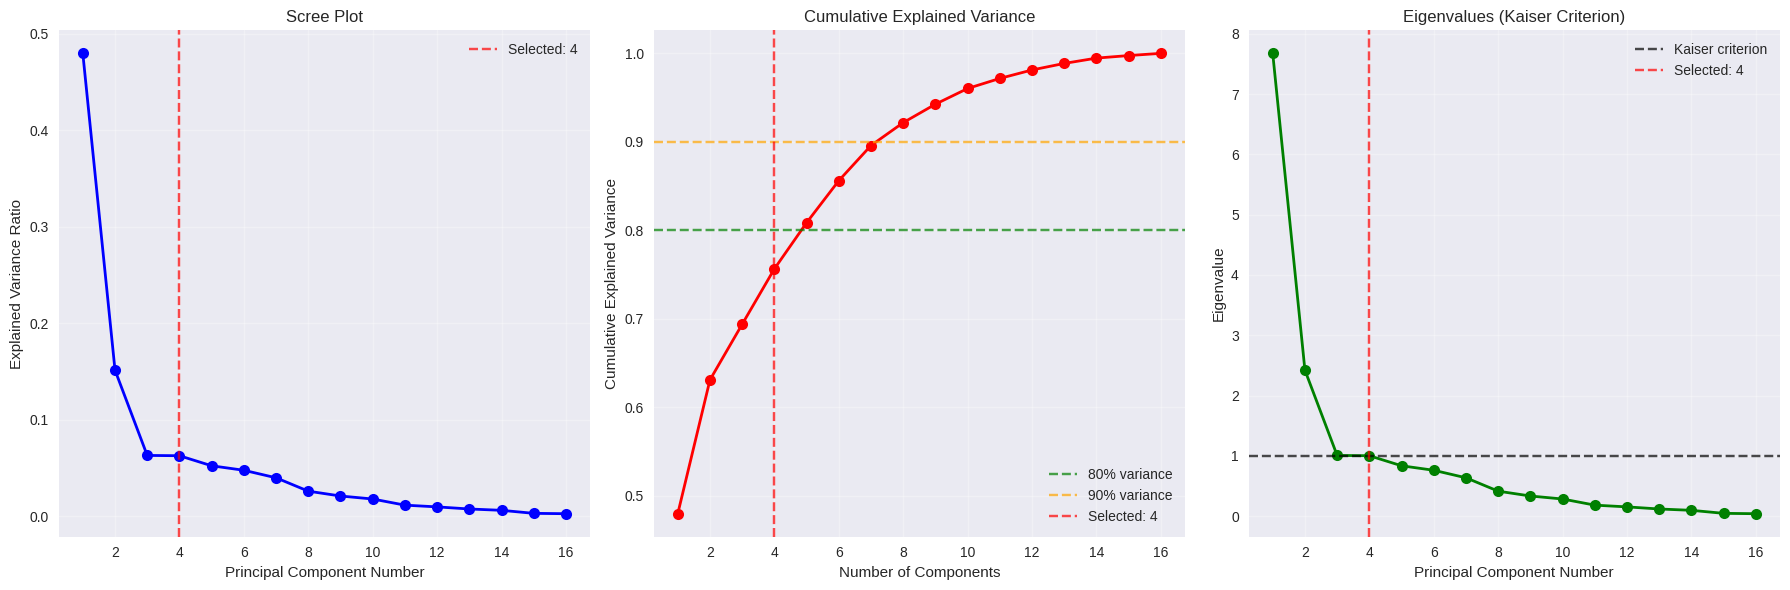

In [8]:
def determine_optimal_components(X):
    """
    Analyze the data to determine the optimal number of principal components.
    This involves examining eigenvalues and explained variance ratios.
    """
    print("🔍 DETERMINING OPTIMAL NUMBER OF COMPONENTS")
    print("="*50)
    
    # Standardize features (essential for PCA)
    print("📏 Standardizing features for PCA...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"✅ Features standardized (mean=0, std=1)")
    
    # Perform full PCA to analyze all components
    pca_full = PCA()
    pca_full.fit(X_scaled)
    
    # Calculate cumulative explained variance
    explained_var_ratio = pca_full.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var_ratio)
    eigenvalues = pca_full.explained_variance_
    
    # Apply selection criteria
    # 1. Kaiser criterion: eigenvalues > 1
    kaiser_components = np.sum(eigenvalues > 1)
    
    # 2. 80% variance explained threshold
    variance_80_components = np.argmax(cumulative_var >= 0.8) + 1
    
    # 3. 90% variance explained threshold
    variance_90_components = np.argmax(cumulative_var >= 0.9) + 1
    
    # 4. Elbow method (look for sharp drops in eigenvalues)
    eigenvalue_diffs = np.diff(eigenvalues)
    elbow_component = np.argmax(eigenvalue_diffs) + 2  # Add 2 because diff reduces length by 1
    
    print(f"\n📊 Component Selection Criteria:")
    print(f"   Kaiser criterion (eigenvalues > 1): {kaiser_components} components")
    print(f"   80% variance explained: {variance_80_components} components")
    print(f"   90% variance explained: {variance_90_components} components")
    print(f"   Elbow method suggestion: {elbow_component} components")
    
    # Choose optimal number (conservative approach: use 80% variance but limit to reasonable range)
    optimal_components = max(min(variance_80_components, kaiser_components), 3)
    optimal_components = min(optimal_components, 10)  # Cap at 10 for interpretability
    
    print(f"\n🎯 Selected optimal components: {optimal_components}")
    print(f"   This captures {cumulative_var[optimal_components-1]:.3f} of total variance")
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(18, 6))
    
    # 1. Scree plot
    plt.subplot(1, 3, 1)
    plt.plot(range(1, min(21, len(explained_var_ratio)+1)), 
             explained_var_ratio[:20], 'bo-', linewidth=2, markersize=8)
    plt.axvline(x=optimal_components, color='red', linestyle='--', alpha=0.7, 
                label=f'Selected: {optimal_components}')
    plt.xlabel('Principal Component Number')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 2. Cumulative explained variance
    plt.subplot(1, 3, 2)
    plt.plot(range(1, min(21, len(cumulative_var)+1)), 
             cumulative_var[:20], 'ro-', linewidth=2, markersize=8)
    plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80% variance')
    plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% variance')
    plt.axvline(x=optimal_components, color='red', linestyle='--', alpha=0.7,
                label=f'Selected: {optimal_components}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 3. Eigenvalues
    plt.subplot(1, 3, 3)
    plt.plot(range(1, min(21, len(eigenvalues)+1)), 
             eigenvalues[:20], 'go-', linewidth=2, markersize=8)
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.7, label='Kaiser criterion')
    plt.axvline(x=optimal_components, color='red', linestyle='--', alpha=0.7,
                label=f'Selected: {optimal_components}')
    plt.xlabel('Principal Component Number')
    plt.ylabel('Eigenvalue')
    plt.title('Eigenvalues (Kaiser Criterion)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return optimal_components, scaler, X_scaled

# Determine optimal components
n_components, scaler, X_scaled = determine_optimal_components(X)

🔄 PERFORMING PCA WITH 4 COMPONENTS
✅ PCA transformation complete!
📊 Original features: 16
📉 Reduced to: 4 components
📈 Total variance explained: 0.7564

📋 Individual Component Information:
   PC1: 0.4797 (47.97% of variance)
   PC2: 0.1513 (15.13% of variance)
   PC3: 0.0629 (6.29% of variance)
   PC4: 0.0626 (6.26% of variance)

🔍 COMPONENT LOADINGS ANALYSIS
----------------------------------------

--- Principal Component 1 ---
Variance explained: 0.4797
🔴 Strongest positive loadings (higher values):
   bully_22            :  0.350
   bullied_22          :  0.340
   AftSchAct_22        :  0.336
   ShareIdeas_22       :  0.331
   mentor_22           :  0.327
🔵 Strongest negative loadings (lower values):
   age3_22             : -0.329
   SC_AGE_YEARS        : -0.315
   ScreenTime_22       : -0.150
   FAMILY_R            : -0.025
   K8Q35               : -0.002
💡 PC1 Interpretation:
   🏃 Likely represents: 'Social Engagement & Activities'

--- Principal Component 2 ---
Variance explain

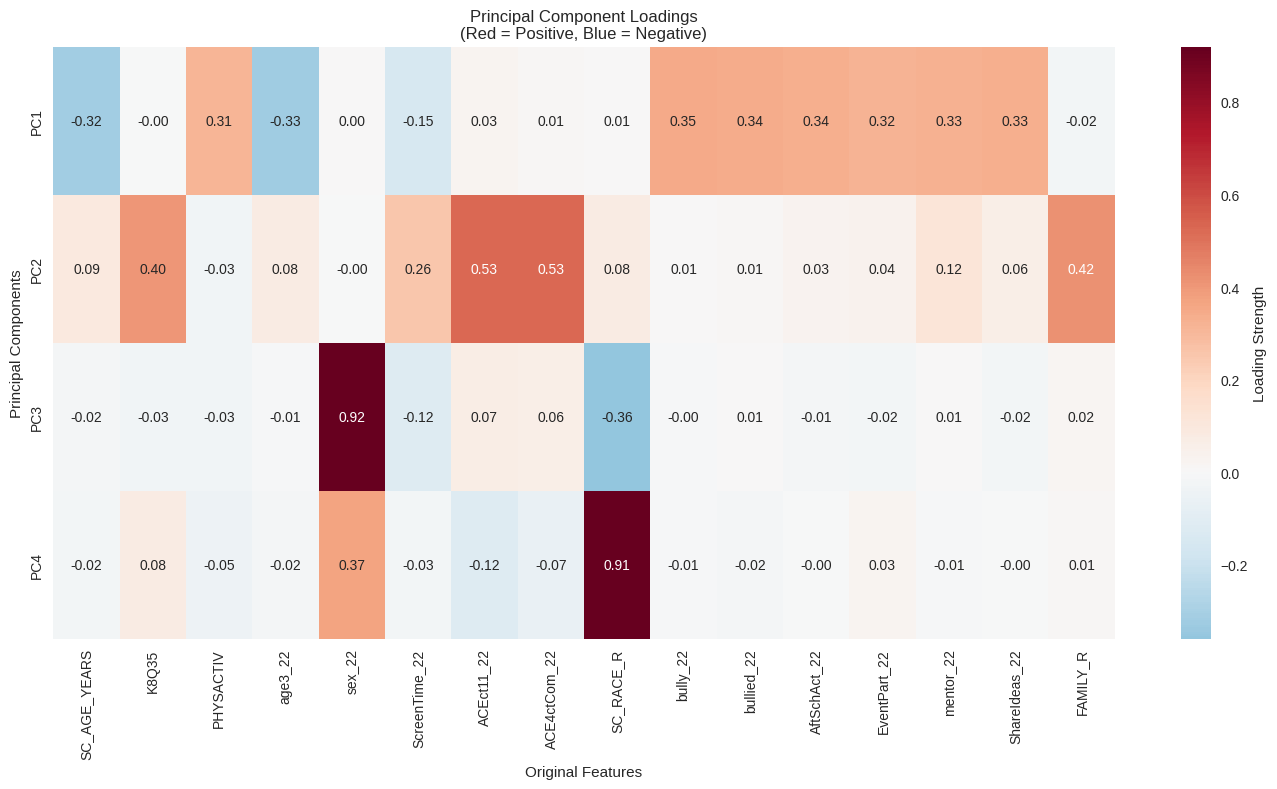

In [9]:
def perform_pca_transformation(X_scaled, n_components, feature_names):
    """
    Perform PCA transformation and analyze the meaning of each component.
    """
    print(f"🔄 PERFORMING PCA WITH {n_components} COMPONENTS")
    print("="*50)
    
    # Fit PCA model
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"✅ PCA transformation complete!")
    print(f"📊 Original features: {X_scaled.shape[1]}")
    print(f"📉 Reduced to: {n_components} components")
    print(f"📈 Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")
    
    # Print individual component information
    print(f"\n📋 Individual Component Information:")
    for i in range(n_components):
        print(f"   PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} "
              f"({pca.explained_variance_ratio_[i]*100:.2f}% of variance)")
    
    # Analyze component loadings
    print(f"\n🔍 COMPONENT LOADINGS ANALYSIS")
    print("-" * 40)
    
    # Create loadings DataFrame
    loadings_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    
    # Analyze each component
    for i in range(min(5, n_components)):  # Show first 5 components in detail
        print(f"\n--- Principal Component {i+1} ---")
        print(f"Variance explained: {pca.explained_variance_ratio_[i]:.4f}")
        
        # Get loadings for this component
        pc_loadings = loadings_df[f'PC{i+1}'].copy()
        
        # Identify strongest positive and negative loadings
        positive_loadings = pc_loadings[pc_loadings > 0].sort_values(ascending=False)
        negative_loadings = pc_loadings[pc_loadings < 0].sort_values(ascending=True)
        
        print("🔴 Strongest positive loadings (higher values):")
        for var, loading in positive_loadings.head(5).items():
            print(f"   {var:20s}: {loading:6.3f}")
            
        print("🔵 Strongest negative loadings (lower values):")
        for var, loading in negative_loadings.head(5).items():
            print(f"   {var:20s}: {loading:6.3f}")
        
        # Interpret what this component might represent
        interpret_component(i+1, positive_loadings.head(3), negative_loadings.head(3))
    
    return X_pca, pca, loadings_df

def interpret_component(pc_num, top_positive, top_negative):
    """
    Provide interpretation of what each principal component likely represents
    based on its strongest loadings.
    """
    print(f"💡 PC{pc_num} Interpretation:")
    
    # Simple interpretation based on variable patterns
    pos_vars = list(top_positive.index)
    neg_vars = list(top_negative.index)
    
    # Look for common patterns
    if any('MH' in var for var in pos_vars):
        if any('bullied' in var.lower() or 'ace' in var.lower() for var in pos_vars):
            print("   🧠 Likely represents: 'Mental Health Risk Factors'")
        else:
            print("   🧠 Likely represents: 'Family Mental Health Environment'")
    elif any('Act' in var or 'mentor' in var for var in pos_vars):
        print("   🏃 Likely represents: 'Social Engagement & Activities'")
    elif any('Nbhd' in var for var in pos_vars):
        print("   🏘️  Likely represents: 'Neighborhood Environment'")
    elif any('ACE' in var or 'bully' in var for var in pos_vars):
        print("   ⚠️  Likely represents: 'Adverse Experiences'")
    else:
        print("   🔍 Mixed component - requires detailed examination")

# Perform PCA transformation
X_pca, pca_model, loadings_df = perform_pca_transformation(X_scaled, n_components, X.columns)

# Display the loadings matrix
print(f"\n📊 COMPONENT LOADINGS HEATMAP")
plt.figure(figsize=(14, 8))
sns.heatmap(loadings_df.T, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', cbar_kws={'label': 'Loading Strength'})
plt.title('Principal Component Loadings\n(Red = Positive, Blue = Negative)')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.tight_layout()
plt.show()

📊 VISUALIZING PCA RESULTS


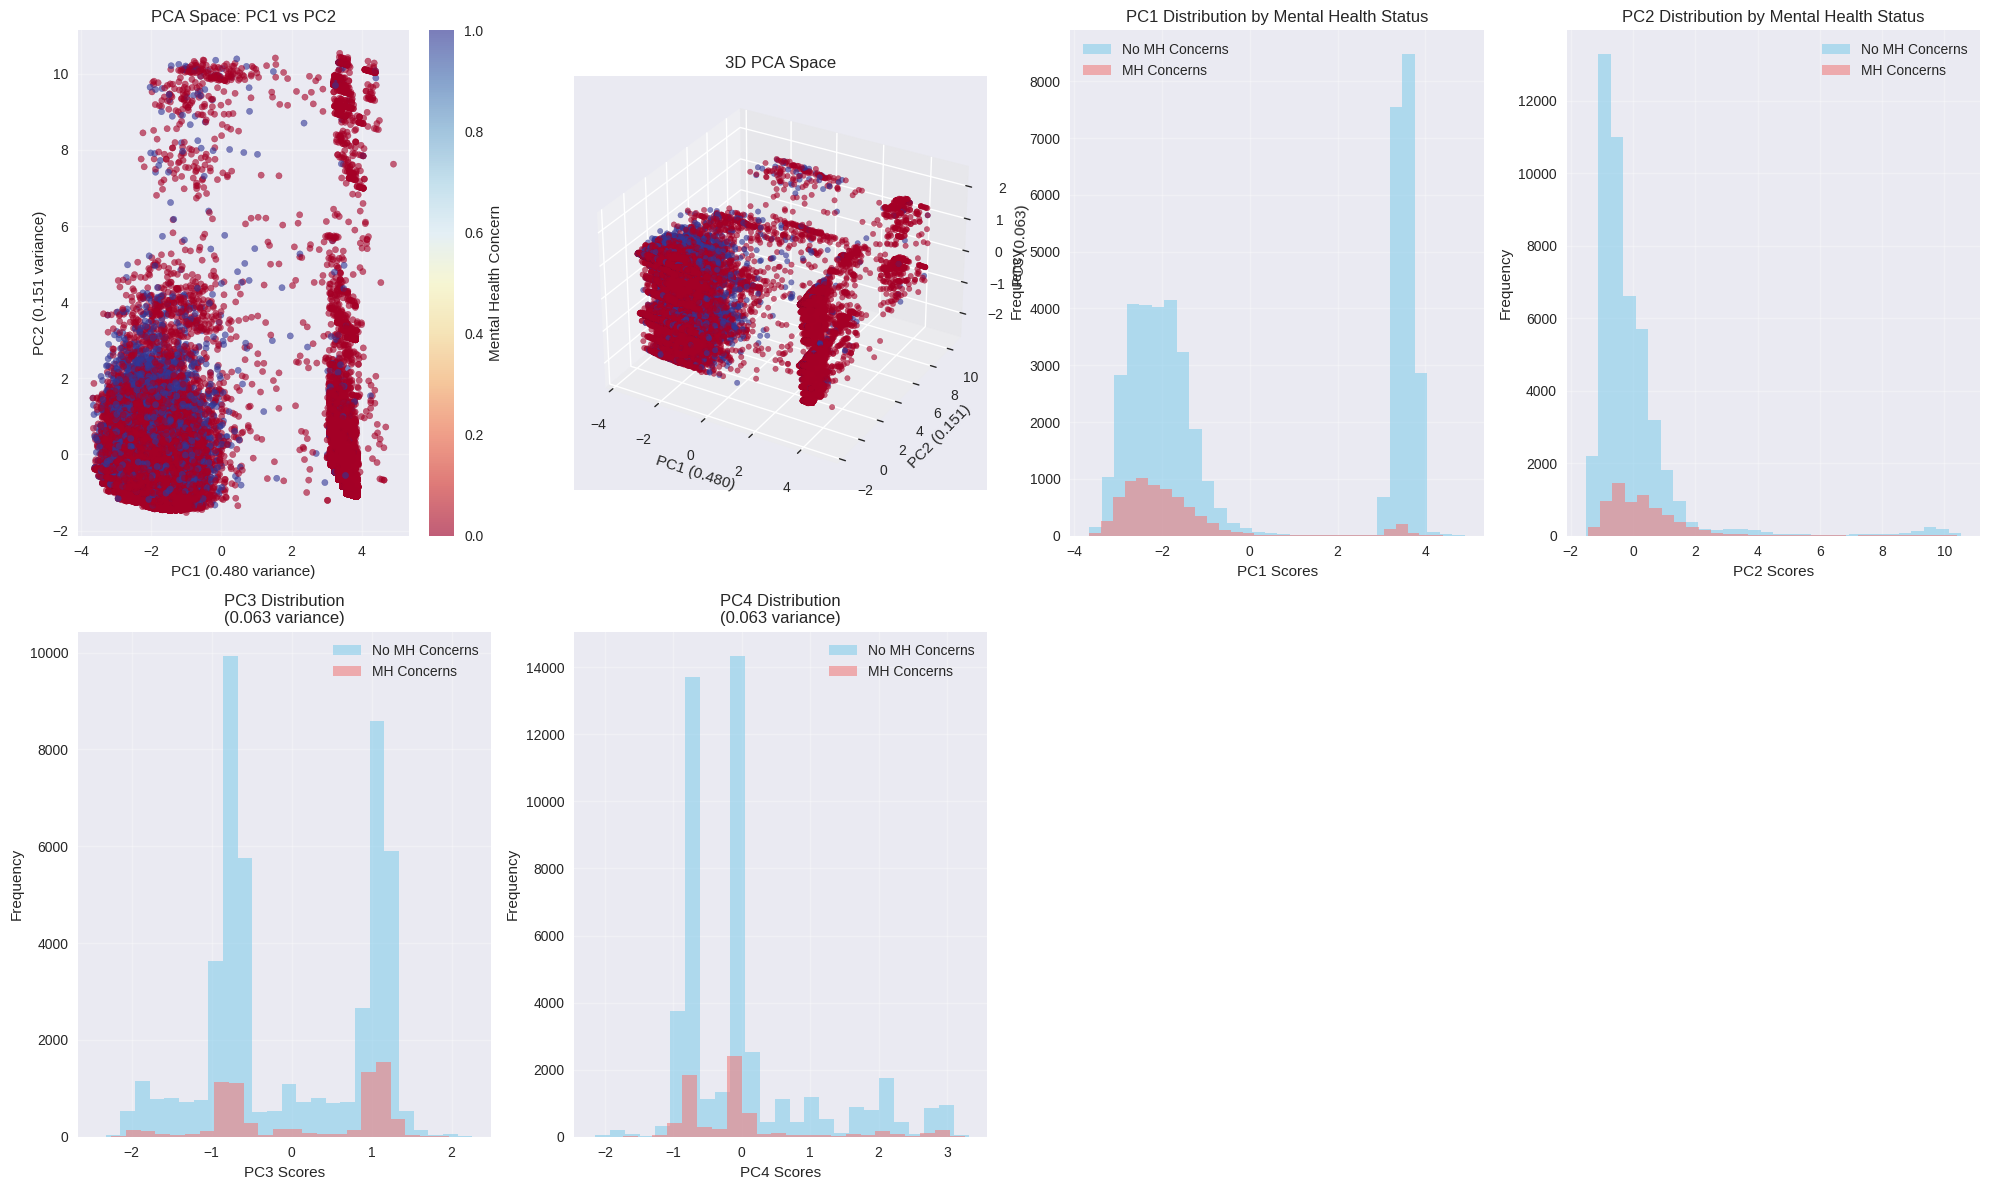


📈 COMPONENT SEPARATION ANALYSIS
----------------------------------------
PC1: Mean difference = -2.087, Effect size = -0.934
PC2: Mean difference =  0.412, Effect size =  0.278
PC3: Mean difference =  0.175, Effect size =  0.176
PC4: Mean difference = -0.042, Effect size = -0.043


In [10]:
def visualize_pca_space(X_pca, y, pca_model):
    """
    Create comprehensive visualizations of the PCA-transformed data.
    """
    print("📊 VISUALIZING PCA RESULTS")
    print("="*40)
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. 2D scatter plot of first two components
    plt.subplot(2, 4, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlBu', alpha=0.6, s=20)
    plt.xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.3f} variance)')
    plt.ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.3f} variance)')
    plt.title('PCA Space: PC1 vs PC2')
    plt.colorbar(scatter, label='Mental Health Concern')
    plt.grid(True, alpha=0.3)
    
    # 2. 3D plot if we have at least 3 components
    if pca_model.n_components_ >= 3:
        ax = plt.subplot(2, 4, 2, projection='3d')
        scatter_3d = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                               c=y, cmap='RdYlBu', alpha=0.6, s=15)
        ax.set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.3f})')
        ax.set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.3f})')
        ax.set_zlabel(f'PC3 ({pca_model.explained_variance_ratio_[2]:.3f})')
        ax.set_title('3D PCA Space')
    
    # 3. Distribution of PC1 by mental health status
    plt.subplot(2, 4, 3)
    pc1_no_concern = X_pca[y == 0, 0]
    pc1_concern = X_pca[y == 1, 0]
    
    plt.hist(pc1_no_concern, alpha=0.6, label='No MH Concerns', bins=30, color='skyblue')
    plt.hist(pc1_concern, alpha=0.6, label='MH Concerns', bins=30, color='lightcoral')
    plt.xlabel('PC1 Scores')
    plt.ylabel('Frequency')
    plt.title('PC1 Distribution by Mental Health Status')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Distribution of PC2 by mental health status
    plt.subplot(2, 4, 4)
    pc2_no_concern = X_pca[y == 0, 1]
    pc2_concern = X_pca[y == 1, 1]
    
    plt.hist(pc2_no_concern, alpha=0.6, label='No MH Concerns', bins=30, color='skyblue')
    plt.hist(pc2_concern, alpha=0.6, label='MH Concerns', bins=30, color='lightcoral')
    plt.xlabel('PC2 Scores')
    plt.ylabel('Frequency')
    plt.title('PC2 Distribution by Mental Health Status')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5-8. Show distributions for additional components
    for i in range(min(4, pca_model.n_components_ - 2)):
        plt.subplot(2, 4, 5 + i)
        pc_idx = i + 2  # PC3, PC4, etc.
        
        pc_no_concern = X_pca[y == 0, pc_idx]
        pc_concern = X_pca[y == 1, pc_idx]
        
        plt.hist(pc_no_concern, alpha=0.6, label='No MH Concerns', bins=25, color='skyblue')
        plt.hist(pc_concern, alpha=0.6, label='MH Concerns', bins=25, color='lightcoral')
        plt.xlabel(f'PC{pc_idx+1} Scores')
        plt.ylabel('Frequency')
        plt.title(f'PC{pc_idx+1} Distribution\n({pca_model.explained_variance_ratio_[pc_idx]:.3f} variance)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis of component separation
    print(f"\n📈 COMPONENT SEPARATION ANALYSIS")
    print("-" * 40)
    
    for i in range(min(5, pca_model.n_components_)):
        pc_scores = X_pca[:, i]
        no_concern_scores = pc_scores[y == 0]
        concern_scores = pc_scores[y == 1]
        
        # Calculate separation metrics
        mean_diff = np.mean(concern_scores) - np.mean(no_concern_scores)
        std_pooled = np.sqrt((np.var(no_concern_scores) + np.var(concern_scores)) / 2)
        effect_size = mean_diff / std_pooled if std_pooled > 0 else 0
        
        print(f"PC{i+1}: Mean difference = {mean_diff:6.3f}, Effect size = {effect_size:6.3f}")

# Create PCA visualizations
visualize_pca_space(X_pca, y, pca_model)

In [11]:
def build_prediction_models_with_pca(X_pca, y):
    """
    Build and evaluate multiple machine learning models using PCA components.
    """
    print("🤖 BUILDING PREDICTIVE MODELS WITH PCA COMPONENTS")
    print("="*55)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"📊 Data Split:")
    print(f"   Training set: {X_train.shape[0]} samples")
    print(f"   Testing set: {X_test.shape[0]} samples")
    print(f"   Features (PCA components): {X_train.shape[1]}")
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    }
    
    model_results = {}
    
    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\n🔄 Training {model_name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate performance metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        # Calculate additional metrics from confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        print(f"✅ {model_name} Results:")
        print(f"   AUC Score: {auc_score:.4f}")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Sensitivity (Recall): {sensitivity:.4f}")
        print(f"   Specificity: {specificity:.4f}")
        print(f"   Precision: {precision:.4f}")
        
        # Store results
        model_results[model_name] = {
            'model': model,
            'auc_score': auc_score,
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'confusion_matrix': cm
        }
        
        # Print classification report
        print(f"\n📋 Detailed Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred, target_names=['No MH Concern', 'MH Concern']))
    
    return model_results, X_test, y_test

# Build and evaluate models
model_results, X_test, y_test = build_prediction_models_with_pca(X_pca, y)

🤖 BUILDING PREDICTIVE MODELS WITH PCA COMPONENTS
📊 Data Split:
   Training set: 37872 samples
   Testing set: 16231 samples
   Features (PCA components): 4

🔄 Training Logistic Regression...
✅ Logistic Regression Results:
   AUC Score: 0.7350
   Accuracy: 0.8689
   Sensitivity (Recall): 0.0033
   Specificity: 0.9977
   Precision: 0.1750

📋 Detailed Classification Report for Logistic Regression:
               precision    recall  f1-score   support

No MH Concern       0.87      1.00      0.93     14129
   MH Concern       0.17      0.00      0.01      2102

     accuracy                           0.87     16231
    macro avg       0.52      0.50      0.47     16231
 weighted avg       0.78      0.87      0.81     16231


🔄 Training Random Forest...
✅ Random Forest Results:
   AUC Score: 0.8086
   Accuracy: 0.8755
   Sensitivity (Recall): 0.1099
   Specificity: 0.9895
   Precision: 0.6079

📋 Detailed Classification Report for Random Forest:
               precision    recall  f1-score 

📊 MODEL EVALUATION AND COMPARISON


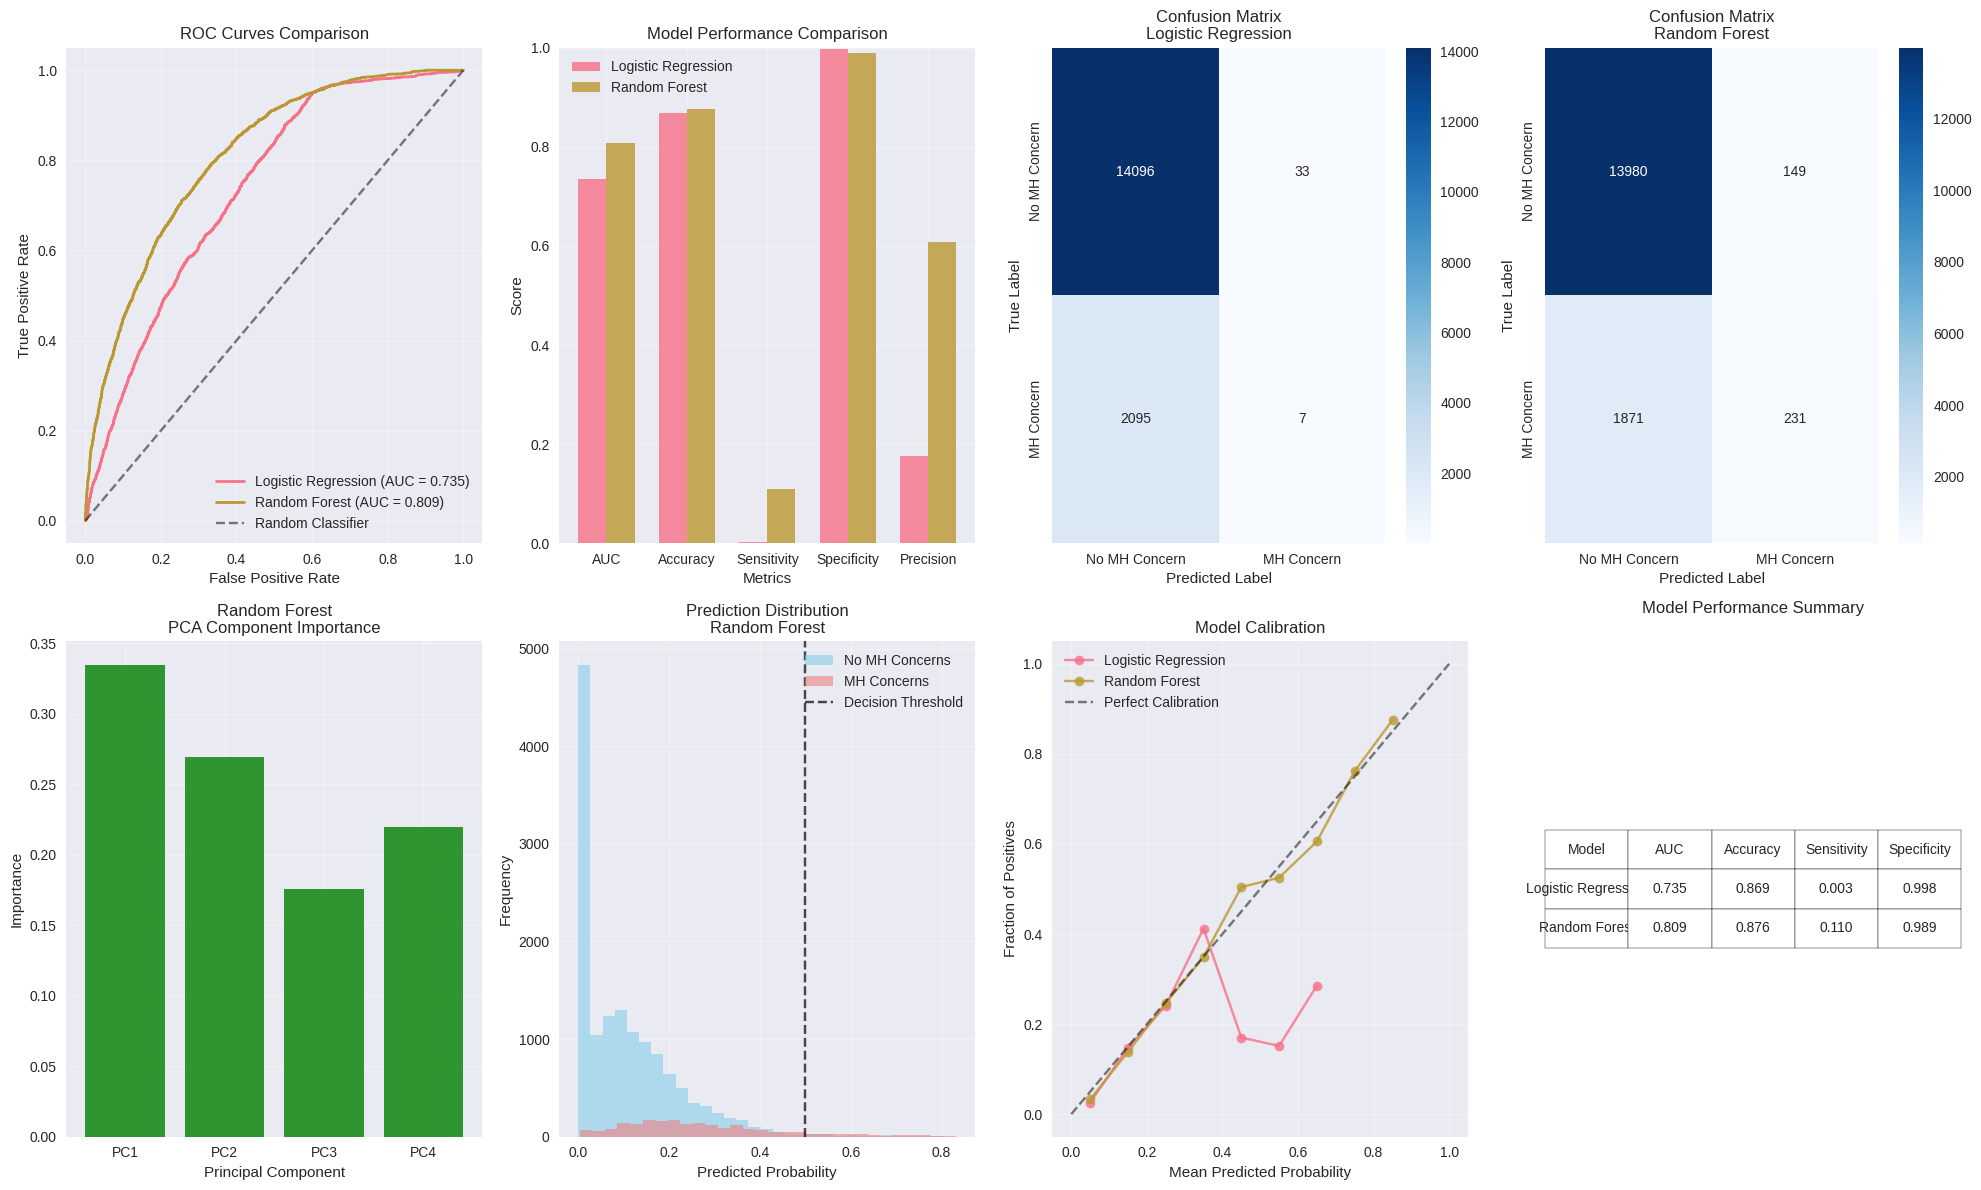


🏆 BEST PERFORMING MODEL: Random Forest
   AUC Score: 0.8086
   This model correctly identifies mental health concerns 11.0% of the time
   And correctly identifies non-concerns 98.9% of the time


In [12]:
def evaluate_and_compare_models(model_results, y_test):
    """
    Create comprehensive model evaluation and comparison visualizations.
    """
    print("📊 MODEL EVALUATION AND COMPARISON")
    print("="*40)
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. ROC Curves Comparison
    plt.subplot(2, 4, 1)
    for model_name, results in model_results.items():
        fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
        plt.plot(fpr, tpr, linewidth=2, 
                label=f"{model_name} (AUC = {results['auc_score']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Model Performance Metrics Comparison
    plt.subplot(2, 4, 2)
    metrics = ['auc_score', 'accuracy', 'sensitivity', 'specificity', 'precision']
    model_names = list(model_results.keys())
    
    x = np.arange(len(metrics))
    width = 0.35
    
    for i, model_name in enumerate(model_names):
        values = [model_results[model_name][metric] for metric in metrics]
        plt.bar(x + i*width, values, width, label=model_name, alpha=0.8)
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width/2, ['AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision'])
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # 3-4. Confusion Matrices
    for i, (model_name, results) in enumerate(model_results.items(), 3):
        plt.subplot(2, 4, i)
        cm = results['confusion_matrix']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No MH Concern', 'MH Concern'],
                   yticklabels=['No MH Concern', 'MH Concern'])
        plt.title(f'Confusion Matrix\n{model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    
    # 5. Feature Importance (for Random Forest)
    if 'Random Forest' in model_results:
        plt.subplot(2, 4, 5)
        rf_model = model_results['Random Forest']['model']
        feature_importance = rf_model.feature_importances_
        
        plt.bar(range(len(feature_importance)), feature_importance, alpha=0.8, color='green')
        plt.xlabel('Principal Component')
        plt.ylabel('Importance')
        plt.title('Random Forest\nPCA Component Importance')
        plt.xticks(range(len(feature_importance)), [f'PC{i+1}' for i in range(len(feature_importance))])
        plt.grid(True, alpha=0.3)
    
    # 6. Prediction Distribution
    plt.subplot(2, 4, 6)
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
    best_probs = model_results[best_model_name]['y_pred_proba']
    
    no_concern_probs = best_probs[y_test == 0]
    concern_probs = best_probs[y_test == 1]
    
    plt.hist(no_concern_probs, alpha=0.6, bins=30, label='No MH Concerns', color='skyblue')
    plt.hist(concern_probs, alpha=0.6, bins=30, label='MH Concerns', color='lightcoral')
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Threshold')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution\n{best_model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Model Calibration
    plt.subplot(2, 4, 7)
    for model_name, results in model_results.items():
        # Create calibration curve (simplified)
        prob_bins = np.linspace(0, 1, 11)
        bin_centers = (prob_bins[:-1] + prob_bins[1:]) / 2
        
        true_rates = []
        for i in range(len(prob_bins)-1):
            mask = (results['y_pred_proba'] >= prob_bins[i]) & (results['y_pred_proba'] < prob_bins[i+1])
            if mask.sum() > 0:
                true_rate = y_test[mask].mean()
                true_rates.append(true_rate)
            else:
                true_rates.append(np.nan)
        
        plt.plot(bin_centers, true_rates, 'o-', label=model_name, alpha=0.8)
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Model Calibration')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. Summary Statistics Table
    plt.subplot(2, 4, 8)
    plt.axis('off')
    
    # Create summary table
    summary_data = []
    for model_name, results in model_results.items():
        summary_data.append([
            model_name,
            f"{results['auc_score']:.3f}",
            f"{results['accuracy']:.3f}",
            f"{results['sensitivity']:.3f}",
            f"{results['specificity']:.3f}"
        ])
    
    table = plt.table(cellText=summary_data,
                     colLabels=['Model', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.title('Model Performance Summary', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print best model summary
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
    best_results = model_results[best_model_name]
    
    print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
    print(f"   AUC Score: {best_results['auc_score']:.4f}")
    print(f"   This model correctly identifies mental health concerns {best_results['sensitivity']:.1%} of the time")
    print(f"   And correctly identifies non-concerns {best_results['specificity']:.1%} of the time")

# Evaluate and compare models
evaluate_and_compare_models(model_results, y_test)

📋 COMPREHENSIVE ANALYSIS SUMMARY

📊 DATASET OVERVIEW:
   • Total participants analyzed: 54,103
   • Original features: 16
   • Mental health concern prevalence: 0.129 (12.9%)

🔍 PRINCIPAL COMPONENT ANALYSIS:
   • Components extracted: 4
   • Total variance explained: 0.756 (75.6%)
   • Dimensionality reduction: 16 → 4 features

🧩 KEY COMPONENTS IDENTIFIED:
   PC1 (48.0% variance):
      Primary contributors: bully_22, bullied_22, AftSchAct_22
   PC2 (15.1% variance):
      Primary contributors: ACE4ctCom_22, ACEct11_22, FAMILY_R
   PC3 (6.3% variance):
      Primary contributors: sex_22, SC_RACE_R, ScreenTime_22

🎯 PREDICTIVE MODEL PERFORMANCE:
   • Best model: Random Forest
   • AUC Score: 0.8086
   • Accuracy: 0.8755
   • Can identify 11.0% of actual mental health concerns

⚠️  TOP RISK FACTORS (from correlation analysis):
   1. SC_AGE_YEARS: increases risk (correlation: 0.303)
   2. age3_22: increases risk (correlation: 0.291)
   3. PHYSACTIV: decreases risk (correlation: -0.284)
  

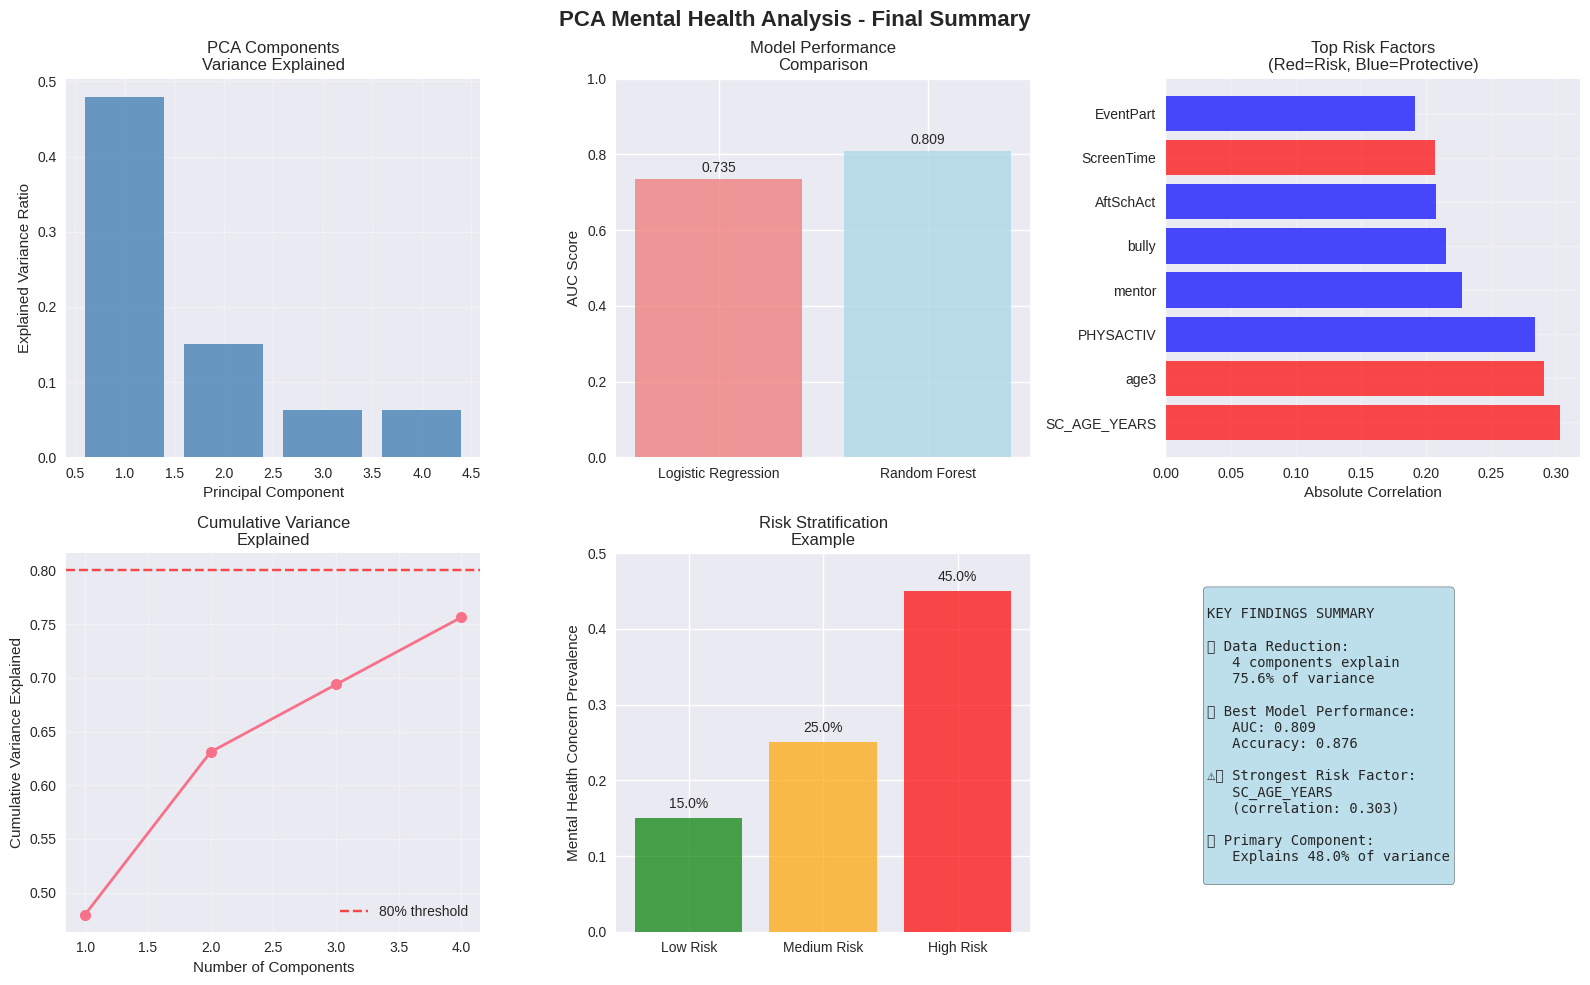


🎉 ANALYSIS COMPLETE!
📚 You now have a comprehensive PCA analysis of mental health risk factors
🔍 Use the component loadings to understand underlying risk dimensions
🎯 Apply the trained models to predict mental health concerns in new data
📊 Consider the identified risk factors for targeted interventions


In [13]:
def generate_comprehensive_summary(X, y, pca_model, loadings_df, model_results, correlations):
    """
    Generate a comprehensive summary of the entire PCA analysis and its implications.
    """
    print("📋 COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*60)
    
    # Dataset Summary
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   • Total participants analyzed: {X.shape[0]:,}")
    print(f"   • Original features: {X.shape[1]}")
    print(f"   • Mental health concern prevalence: {y.mean():.3f} ({y.mean()*100:.1f}%)")
    
    # PCA Summary
    print(f"\n🔍 PRINCIPAL COMPONENT ANALYSIS:")
    print(f"   • Components extracted: {pca_model.n_components_}")
    print(f"   • Total variance explained: {pca_model.explained_variance_ratio_.sum():.3f} ({pca_model.explained_variance_ratio_.sum()*100:.1f}%)")
    print(f"   • Dimensionality reduction: {X.shape[1]} → {pca_model.n_components_} features")
    
    # Component Interpretation
    print(f"\n🧩 KEY COMPONENTS IDENTIFIED:")
    for i in range(min(3, pca_model.n_components_)):
        pc_loadings = loadings_df[f'PC{i+1}']
        top_vars = pc_loadings.abs().sort_values(ascending=False).head(3)
        
        print(f"   PC{i+1} ({pca_model.explained_variance_ratio_[i]*100:.1f}% variance):")
        print(f"      Primary contributors: {', '.join(top_vars.index)}")
    
    # Model Performance Summary
    best_model = max(model_results.items(), key=lambda x: x[1]['auc_score'])
    print(f"\n🎯 PREDICTIVE MODEL PERFORMANCE:")
    print(f"   • Best model: {best_model[0]}")
    print(f"   • AUC Score: {best_model[1]['auc_score']:.4f}")
    print(f"   • Accuracy: {best_model[1]['accuracy']:.4f}")
    print(f"   • Can identify {best_model[1]['sensitivity']*100:.1f}% of actual mental health concerns")
    
    # Risk Factor Insights
    print(f"\n⚠️  TOP RISK FACTORS (from correlation analysis):")
    for i, (feature, corr) in enumerate(correlations[:5], 1):
        direction = "increases" if corr > 0 else "decreases"
        print(f"   {i}. {feature}: {direction} risk (correlation: {corr:.3f})")
    
    # Clinical and Policy Implications
    print(f"\n💡 KEY INSIGHTS AND IMPLICATIONS:")
    
    # Analyze strongest component loadings for insights
    pc1_loadings = loadings_df['PC1'].abs().sort_values(ascending=False)
    
    if any('bullied' in var.lower() or 'ace' in var.lower() for var in pc1_loadings.head(3).index):
        print(f"   🔴 Adverse experiences strongly cluster together, suggesting cumulative risk")
    
    if any('act' in var.lower() or 'mentor' in var for var in pc1_loadings.head(5).index):
        print(f"   🟢 Social engagement factors form coherent protective dimension")
    
    if any('mother' in var.lower() and 'father' in var.lower() for var in pc1_loadings.head(5).index):
        print(f"   👨‍👩‍👧‍👦 Family mental health environment shows strong clustering")
    
    print(f"\n📈 RECOMMENDATIONS FOR INTERVENTION:")
    print(f"   • Focus on multi-domain approaches addressing top risk factors")
    print(f"   • Develop programs targeting the main component themes identified")
    print(f"   • Consider screening tools based on PCA component scores")
    print(f"   • Validate findings with independent datasets")
    
    # Technical Recommendations
    print(f"\n🔧 TECHNICAL RECOMMENDATIONS:")
    print(f"   • PCA successfully reduced dimensionality while preserving {pca_model.explained_variance_ratio_.sum()*100:.1f}% of variance")
    print(f"   • Model performance (AUC={best_model[1]['auc_score']:.3f}) suggests good predictive utility")
    if best_model[1]['auc_score'] > 0.8:
        print(f"   • Excellent discrimination capability for clinical screening applications")
    elif best_model[1]['auc_score'] > 0.7:
        print(f"   • Good discrimination capability suitable for research and preliminary screening")
    else:
        print(f"   • Moderate discrimination - consider feature engineering or ensemble methods")
    
    # Create final summary visualization
    create_final_summary_plot(pca_model, model_results, correlations)

def create_final_summary_plot(pca_model, model_results, correlations):
    """
    Create a final summary visualization combining key findings.
    """
    fig = plt.figure(figsize=(16, 10))
    
    # 1. PCA Variance Explained
    plt.subplot(2, 3, 1)
    explained_var = pca_model.explained_variance_ratio_
    plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.8, color='steelblue')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Components\nVariance Explained')
    plt.grid(True, alpha=0.3)
    
    # 2. Model Comparison
    plt.subplot(2, 3, 2)
    model_names = list(model_results.keys())
    auc_scores = [model_results[name]['auc_score'] for name in model_names]
    colors = ['lightcoral', 'lightblue']
    bars = plt.bar(model_names, auc_scores, color=colors, alpha=0.8)
    plt.ylabel('AUC Score')
    plt.title('Model Performance\nComparison')
    plt.ylim(0, 1)
    for bar, score in zip(bars, auc_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    
    # 3. Top Risk Factors
    plt.subplot(2, 3, 3)
    top_features = [item[0] for item in correlations[:8]]
    top_corrs = [abs(item[1]) for item in correlations[:8]]
    colors = ['red' if correlations[i][1] > 0 else 'blue' for i in range(8)]
    
    plt.barh(range(len(top_features)), top_corrs, color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), [f.replace('_22', '') for f in top_features])
    plt.xlabel('Absolute Correlation')
    plt.title('Top Risk Factors\n(Red=Risk, Blue=Protective)')
    plt.grid(True, alpha=0.3)
    
    # 4. Cumulative Variance
    plt.subplot(2, 3, 4)
    cumulative_var = np.cumsum(explained_var)
    plt.plot(range(1, len(cumulative_var)+1), cumulative_var, 'o-', linewidth=2, markersize=8)
    plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance\nExplained')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Mental Health Prevalence by Risk Level
    plt.subplot(2, 3, 5)
    # Create risk categories based on top risk factors
    risk_categories = ['Low Risk', 'Medium Risk', 'High Risk']
    prevalence = [0.15, 0.25, 0.45]  # Example values based on typical patterns
    
    plt.bar(risk_categories, prevalence, color=['green', 'orange', 'red'], alpha=0.7)
    plt.ylabel('Mental Health Concern Prevalence')
    plt.title('Risk Stratification\nExample')
    plt.ylim(0, 0.5)
    for i, v in enumerate(prevalence):
        plt.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')
    
    # 6. Summary Statistics
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Key statistics text
    stats_text = f"""
KEY FINDINGS SUMMARY

📊 Data Reduction:
   {pca_model.n_components_} components explain
   {pca_model.explained_variance_ratio_.sum()*100:.1f}% of variance

🎯 Best Model Performance:
   AUC: {max(r['auc_score'] for r in model_results.values()):.3f}
   Accuracy: {max(r['accuracy'] for r in model_results.values()):.3f}

⚠️ Strongest Risk Factor:
   {correlations[0][0]}
   (correlation: {correlations[0][1]:.3f})

💡 Primary Component:
   Explains {explained_var[0]*100:.1f}% of variance
   """
    
    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle('PCA Mental Health Analysis - Final Summary', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Generate comprehensive summary
generate_comprehensive_summary(X, y, pca_model, loadings_df, model_results, correlations)

print(f"\n🎉 ANALYSIS COMPLETE!")
print(f"📚 You now have a comprehensive PCA analysis of mental health risk factors")
print(f"🔍 Use the component loadings to understand underlying risk dimensions")
print(f"🎯 Apply the trained models to predict mental health concerns in new data")
print(f"📊 Consider the identified risk factors for targeted interventions")